In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/cedar/signatures/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cedar/signatures


In [14]:
# Imports
from torch.optim import RMSprop, Adam
from torch.utils.data import DataLoader
import numpy as np
from torch import save
from torch import load
from torch.nn import Linear, Conv2d, MaxPool2d, LocalResponseNorm, Dropout
from torch.nn.functional import relu
from torch.nn import Module
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch import Tensor
import torchsummary
import torch

from sklearn.model_selection import train_test_split
import numpy as np

from PIL import Image
from PIL.ImageOps import invert
import pickle
from random import randrange

In [56]:
# Inverts an input image
def invert_image_(path):
    image_file = Image.open(path) 
    image_file = image_file.convert('L').resize([220, 155])
    image_file = invert(image_file)
    image_array = np.array(image_file)
    for i in range(image_array.shape[0]):
        for j in range(image_array.shape[1]):
            if image_array[i][j] <= 50:
                image_array[i][j] = 0
            else:
                image_array[i][j] = 255
    return image_array

In [57]:
# The base paths of the images to be used for the model
base_path_org = 'signatures/full_org/original_%d_%d.png'
base_path_forg = 'signatures/full_forg/forgeries_%d_%d.png'

# Gets the corresponding index for a given x
def fix_pair(x, y):
    if x == y:
        return fix_pair(x, randrange(1, 24))
    else:
        return x, y


data = []
n_samples_of_each_class = 13500

# Creating the dataset needed for SigNet 
for i in range(n_samples_of_each_class):
    anchor_person = randrange(1, 55)
    anchor_sign = randrange(1, 24)
    pos_sign = randrange(1, 24)
    neg_sign = randrange(1, 24)
    anchor_sign, pos_sign = fix_pair(anchor_sign, pos_sign)
    
    positive = [base_path_org % (anchor_person, anchor_sign), base_path_org % (anchor_person, pos_sign), 1]
    negative = [base_path_org % (anchor_person, anchor_sign), base_path_forg % (anchor_person, neg_sign), 0]
    data.append(positive)
    data.append(negative)

# Serialising the test and train set indexes to the disc
train, test = train_test_split(data, test_size=0.15)
with open('train_index.pkl', 'wb') as train_index_file:
    pickle.dump(train, train_index_file)

with open('test_index.pkl', 'wb') as test_index_file:
    pickle.dump(test, test_index_file)


# The traing dataloader
class Train(Dataset):

    def __init__(self):
        with open('train_index.pkl', 'rb') as train_index_file:
            self.pairs = pickle.load(train_index_file)

    def __getitem__(self, index):
        item = self.pairs[index]
        X = Tensor(invert_image_(item[0])/255.0).view(1, 220, 155)
        Y = Tensor(invert_image_(item[1])/255.0).view(1, 220, 155)
        return [X, Y, item[2]]

    def __len__(self):
        return len(self.pairs)

# The test data loader
class Test(Dataset):

    def __init__(self):
        with open('test_index.pkl', 'rb') as test_index_file:
            self.pairs = pickle.load(test_index_file)

    def __getitem__(self, index):
        item = self.pairs[index]
        X = Tensor(invert_image_(item[0])/255.0).view(1, 220, 155)
        Y = Tensor(invert_image_(item[1])/255.0).view(1, 220, 155)
        return [X, Y, item[2]]

    def __len__(self):
        return len(self.pairs)

In [17]:
# Defining the signature net model
class SigNet(Module):
    def __init__(self):
        super(SigNet,self).__init__()
        self.conv1 = Conv2d(1, 48, kernel_size=(11, 11), stride=1)
        self.lrn1 = LocalResponseNorm(48, alpha=1e-4, beta=0.75, k=2)
        self.pool1 = MaxPool2d(kernel_size=(3, 3), stride=2)
        self.conv2 = Conv2d(48, 128, kernel_size=(5, 5), stride=1, padding=2)
        self.lrn2 = LocalResponseNorm(128, alpha=1e-4, beta=0.75, k=2)
        self.pool2 = MaxPool2d(kernel_size=(3, 3), stride=2)
        self.dropout1 = Dropout(0.3)
        self.conv3 = Conv2d(128, 256, kernel_size=(3, 3), stride=1, padding=1)
        self.conv4 = Conv2d(256, 96, kernel_size=(3, 3), stride=1, padding=1)
        self.pool3 = MaxPool2d(kernel_size=(3, 3), stride=2)
        self.dropout2 = Dropout(0.3)
        self.fc1 = Linear(40800, 1024)
        self.dropout3 = Dropout(0.5)
        self.fc2 = Linear(1024, 128)

    def forward_once(self, x):
        x = relu(self.conv1(x))
        x = self.lrn1(x)
        x = self.pool1(x)
        x = relu(self.conv2(x))
        x = self.lrn2(x)
        x = self.pool2(x)
        x = self.dropout1(x)
        x = relu(self.conv3(x))
        x = relu(self.conv4(x))
        x = self.pool3(x)
        x = self.dropout2(x)
        x = x.view(-1, 40800)
        x = relu(self.fc1(x))
        x = self.dropout3(x)
        x = relu(self.fc2(x))
        return x

    def forward(self, x, y):
        pass_x = self.forward_once(x)
        pass_y = self.forward_once(y)
        return pass_x, pass_y

# Custom contrastive loss function which is used by SigNet
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output_X, output_Y, label):
        diff = output_X - output_Y
        dist_sq = torch.sum(torch.pow(diff, 2), 1)
        dist = torch.sqrt(dist_sq)

        mdist = self.margin - dist
        dist = torch.clamp(mdist, min=0.0)
        loss = label * dist_sq + (1 - label) * torch.pow(dist, 2)
        loss = torch.sum(loss) / 2.0 / x0.size()[0]
        return loss

In [9]:
# Selecting GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Different hyperparameters and optimizers used for training
# model = Net()
lr = 0.01
momentum = 0.9
log_interval = 2
# print(model)

model = SigNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
epochs = 5

# optimizer = optim.Adam(model.parameters(), lr = 0.001)

decayRate = 0.96
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)


criterion = ContrastiveLoss()
# optimizer = Adam(model.parameters())

# Creating dataloaders
train_dataset = Train()
train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True)

test_dataset = Test()
val_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# The train function
def train(epoch):
    model.train()
    losses = []
    for batch_idx, (data, target, label) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        # output = model(data)
        output_data, output_target = model(data, target)
        # loss = F.nll_loss(output, target)
        # loss = F.cross_entropy(output, label)
        loss = criterion(output_data, output_target, label)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

# def validation():
#     model.eval()
#     validation_loss = 0
#     correct = 0
#     for data, target, label in val_loader:
#         output_data, output_target = model(data, target)
#         validation_loss += criterion(output_data, output_target, label)
#         eucledian_distance = F.pairwise_distance(output_data, output_target)

#         # validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
#         # pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
#         # correct += pred.eq(target.data.view_as(pred)).cpu().sum()

#     validation_loss /= len(val_loader.dataset)
#     print('\nValidation set: Average loss: {:.4f}\n'.format(validation_loss))

# List of training losses
losses_list = []
for epoch in range(1, epochs + 1):
    losses_list.extend(train(epoch))
    # validation()
    lr_scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

cuda:0
Train Epoch: 1 [0/21600 (0%)]	Loss: 1.489912
Train Epoch: 1 [96/21600 (0%)]	Loss: 1.796358
Train Epoch: 1 [192/21600 (1%)]	Loss: 1.652818
Train Epoch: 1 [288/21600 (1%)]	Loss: 1.032117
Train Epoch: 1 [384/21600 (2%)]	Loss: 1.050301
Train Epoch: 1 [480/21600 (2%)]	Loss: 1.022935
Train Epoch: 1 [576/21600 (3%)]	Loss: 1.189441
Train Epoch: 1 [672/21600 (3%)]	Loss: 1.022112
Train Epoch: 1 [768/21600 (4%)]	Loss: 1.031945
Train Epoch: 1 [864/21600 (4%)]	Loss: 0.993845
Train Epoch: 1 [960/21600 (4%)]	Loss: 1.191168
Train Epoch: 1 [1056/21600 (5%)]	Loss: 1.060244
Train Epoch: 1 [1152/21600 (5%)]	Loss: 1.164257
Train Epoch: 1 [1248/21600 (6%)]	Loss: 1.033430
Train Epoch: 1 [1344/21600 (6%)]	Loss: 0.990359
Train Epoch: 1 [1440/21600 (7%)]	Loss: 1.048132
Train Epoch: 1 [1536/21600 (7%)]	Loss: 1.000458
Train Epoch: 1 [1632/21600 (8%)]	Loss: 1.066216
Train Epoch: 1 [1728/21600 (8%)]	Loss: 1.082134
Train Epoch: 1 [1824/21600 (8%)]	Loss: 1.058573
Train Epoch: 1 [1920/21600 (9%)]	Loss: 1.059840

In [31]:
model = SigNet()
print(model)

SigNet(
  (conv1): Conv2d(1, 48, kernel_size=(11, 11), stride=(1, 1))
  (lrn1): LocalResponseNorm(48, alpha=0.0001, beta=0.75, k=2)
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (lrn2): LocalResponseNorm(128, alpha=0.0001, beta=0.75, k=2)
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=40800, out_features=1024, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
)


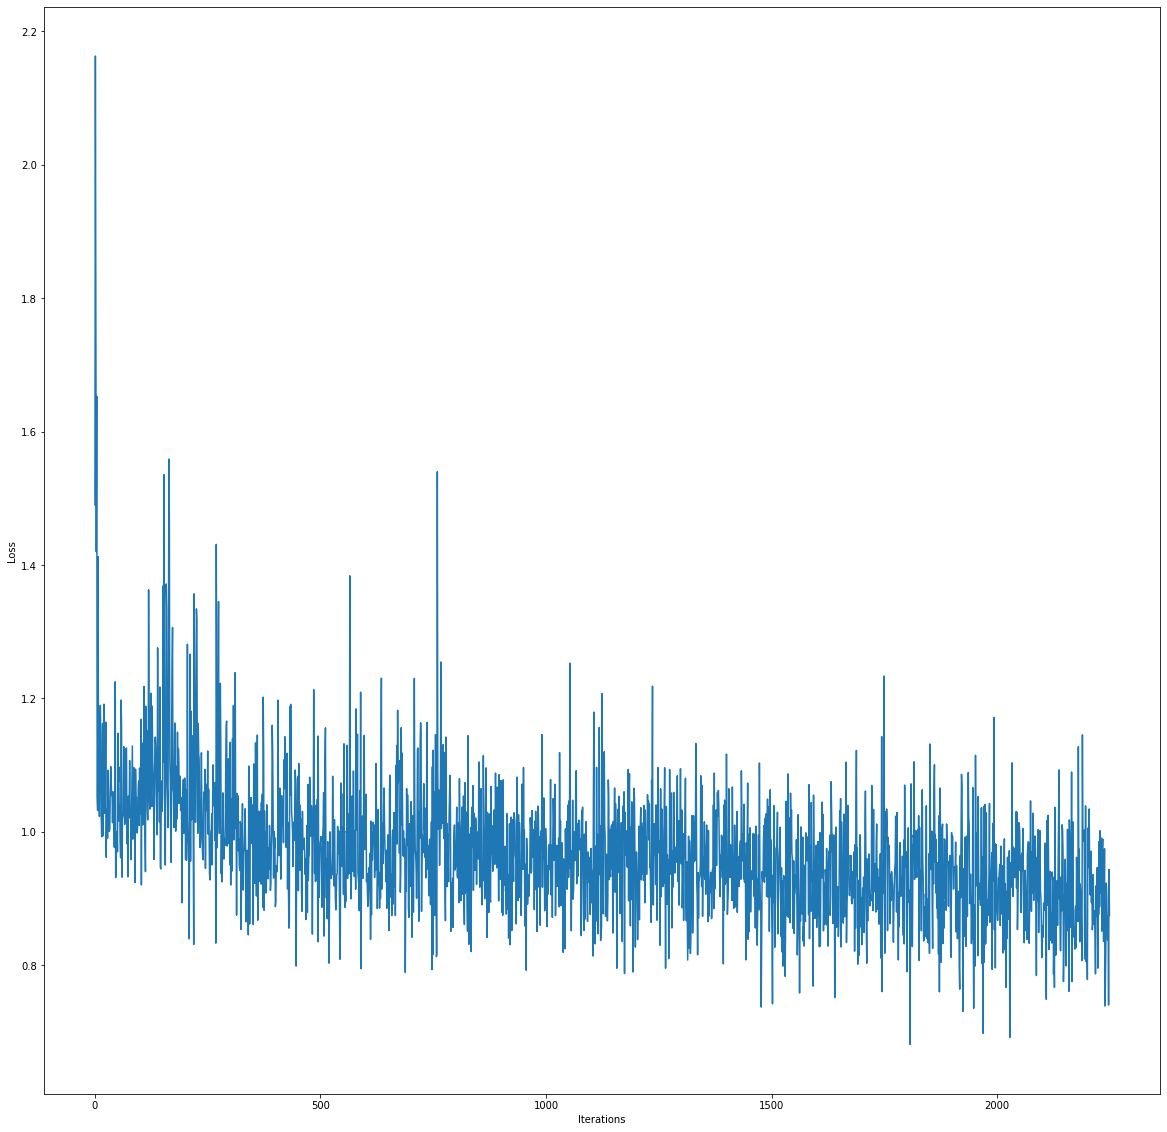

In [32]:
import matplotlib.pyplot as plt

# Plotting the losses
plt.rcParams['figure.figsize'] = [20, 20]
plt.plot(losses_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [58]:
# Testing the model
model = SigNet()
model.load_state_dict(load(open('model_5.pth', 'rb'), map_location=device))
# model.to(device)
model.eval()

test_dataset = Test()
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# A function which computes ROC for calculating the accuracy 
def roc(predictions, labels):
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
    step = 0.001
    max_accuracy = 0

    for dist in np.arange(dmin, dmax + step, step):
        idx1 = predictions.ravel() <= dist
        idx2 = predictions.ravel() > dist

        tpr = float(np.sum(labels[idx1] == 1)) / nsame
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff

        accuracy = 0.5 * (tpr + tnr)

        if accuracy > max_accuracy:
            max_accuracy = accuracy

    return max_accuracy


batch_avg_accuracy = 0
n_batch = 0

# Testing the model
def test():
    global batch_avg_accuracy
    global n_batch
    for batch_index, (dataA, dataB, labels) in enumerate(test_loader):
        pass_a, pass_b = model.forward(dataA, dataB)
        dist = F.pairwise_distance(pass_a, pass_b)

        accuracy = roc(dist.detach().numpy(), labels.long().detach().numpy())
        batch_avg_accuracy += accuracy
        n_batch += 1
        print('Accuracy for batch {} = {}'.format(batch_index, accuracy))
        
# Printing the overall accuracy
test()
print('Overall accuracy for all the batches = {}'.format(batch_avg_accuracy / n_batch))

Accuracy for batch 0 = 0.6666666666666666
Accuracy for batch 1 = 0.8333333333333333
Accuracy for batch 2 = 0.8333333333333333
Accuracy for batch 3 = 1.0
Accuracy for batch 4 = 0.8333333333333333
Accuracy for batch 5 = 0.8333333333333333
Accuracy for batch 6 = 0.75
Accuracy for batch 7 = 0.5833333333333334
Accuracy for batch 8 = 0.75
Accuracy for batch 9 = 0.9
Accuracy for batch 10 = 0.8333333333333333
Accuracy for batch 11 = 0.6333333333333333
Accuracy for batch 12 = 0.9
Accuracy for batch 13 = 1.0
Accuracy for batch 14 = 0.5
Accuracy for batch 15 = 0.9166666666666667
Accuracy for batch 16 = 0.75
Accuracy for batch 17 = 0.5833333333333334
Accuracy for batch 18 = 0.625
Accuracy for batch 19 = 0.75
Accuracy for batch 20 = 0.5
Accuracy for batch 21 = 0.5714285714285714
Accuracy for batch 22 = 0.75
Accuracy for batch 23 = 0.8
Accuracy for batch 24 = 0.8
Accuracy for batch 25 = 0.625
Accuracy for batch 26 = 0.75
Accuracy for batch 27 = 0.75
Accuracy for batch 28 = 0.8
Accuracy for batch 29 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Accuracy for batch 55 = 0
Accuracy for batch 56 = 0.5
Accuracy for batch 57 = 0.875
Accuracy for batch 58 = 0.75
Accuracy for batch 59 = 0.5833333333333333
Accuracy for batch 60 = 0.75
Accuracy for batch 61 = 1.0
Accuracy for batch 62 = 0.8
Accuracy for batch 63 = 0.75
Accuracy for batch 64 = 1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


Accuracy for batch 65 = 0
Accuracy for batch 66 = 0.75
Accuracy for batch 67 = 0.8333333333333333
Accuracy for batch 68 = 0.875
Accuracy for batch 69 = 0.75
Accuracy for batch 70 = 0.875
Accuracy for batch 71 = 0.875
Accuracy for batch 72 = 0.625
Accuracy for batch 73 = 1.0
Accuracy for batch 74 = 0.75
Accuracy for batch 75 = 0.8
Accuracy for batch 76 = 1.0
Accuracy for batch 77 = 0.75
Accuracy for batch 78 = 0.9
Accuracy for batch 79 = 0.8333333333333333
Accuracy for batch 80 = 0.9
Accuracy for batch 81 = 0.8
Accuracy for batch 82 = 0.9166666666666667
Accuracy for batch 83 = 1.0
Accuracy for batch 84 = 0.8333333333333333
Accuracy for batch 85 = 0.9166666666666667
Accuracy for batch 86 = 0.625
Accuracy for batch 87 = 0.6333333333333333
Accuracy for batch 88 = 1.0
Accuracy for batch 89 = 0.7142857142857143
Accuracy for batch 90 = 0.9285714285714286
Accuracy for batch 91 = 0.7333333333333334
Accuracy for batch 92 = 1.0
Accuracy for batch 93 = 0.8333333333333333
Accuracy for batch 94 = 0.